In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import pandas as pd

import emailData as eD
import helper_functions as hf

In [2]:
base_dir = './'
fn = 'enron-event-history-all.csv'
df = pd.read_csv(base_dir + fn, header = None)
eData = eD.emailData(df)
eData.counts_df.to_csv('part1.csv', index = False)

In [3]:
num_days = 14
nt_ag = eData.name_time_aggregate(min(eData.transformed_df.time.values), max(eData.transformed_df.time.values), num_days)
prolific = [table[table.person.isin(eData.prolific_senders)] for table in nt_ag]
data_to_plot = [[table[table.person == person].sent.values[0] for table in prolific] for person in eData.prolific_senders]
cumulative = [[np.array(data[:i]).sum() for i in xrange(len(data_to_plot[0])-1) ]for data in data_to_plot]

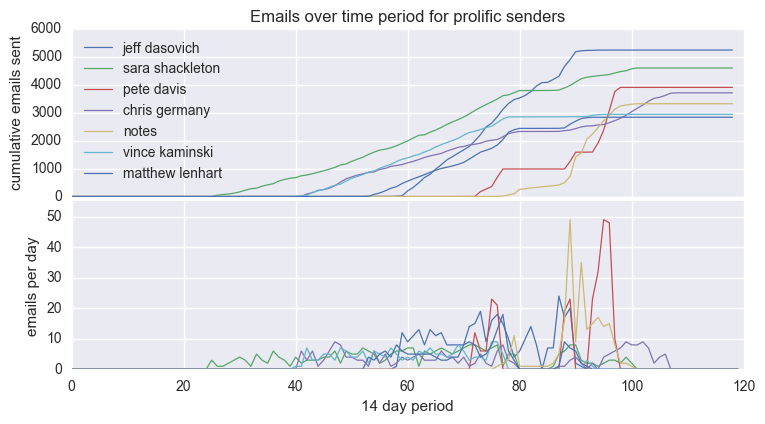

In [4]:
num_to_plot = 7
axis_legend = True

fig = plt.figure(figsize = (1.2*8,1.2*4))
axis1 = fig.add_axes([0.15, 0.14, 0.7, 0.35])
axis2 = fig.add_axes([0.15, 0.5, 0.7, 0.35])
for i in xrange(num_to_plot):
    plt.sca(axis1)
    plt.plot(np.array(data_to_plot[i])/num_days,'-', label = eData.prolific_senders[i], alpha = 1, linewidth  =0.9)
    plt.sca(axis2)
    plt.plot(cumulative[i], label = eData.prolific_senders[i], alpha = 1, linewidth = 0.9)
plt.sca(axis1)

plt.xlabel('%0d day period'%num_days)
plt.ylabel('emails per day')

plt.ylim(0, 55)

plt.sca(axis2)
plt.ylabel('cumulative emails sent')
if axis_legend: 
    plt.legend(loc = 2)
axis2.set_xticklabels([])

plt.title('Emails over time period for prolific senders')
#plt.yscale('log')
plt.savefig('part2.png')


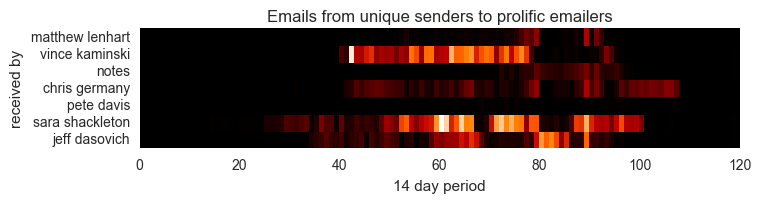

In [5]:
rfrom = []
names_list = eData.prolific_senders[:num_to_plot]

for k in xrange(len(eData.current_time_ag)):
    ie = hf.get_individual_emails(eData.current_time_ag[k])
    rfrom.append(hf.get_unique_sent_received_counts(ie, names_list).unique_received_from.values)
    
rfrom = np.array(rfrom, dtype = int)

factor = len(names_list)/4


fig = plt.figure(figsize = (factor*8,factor*2))
ax = fig.add_axes([0.2, 0.25, 0.75, 0.6])
ax.pcolormesh(rfrom.T, cmap='gist_heat')
plt.yticks(np.array(range(len(names_list)), dtype = float) + 0.5)
ax.set_yticklabels(names_list)
plt.xlabel('%0d day period'%num_days)
plt.ylabel('received by')
plt.title('Emails from unique senders to prolific emailers')
plt.savefig('part3.png')